# Signal de-spiking in LaserTRAM

Most of the time we do not have to worry about signal de-spiking. However, there are numerous things that can cause a signal to seemingly randomly spike and significantly deviate from the rest of the timeseries for a single sweep through the mass range. Since this is often an orders of magnitude change, it significantly affects the standard deviation of the normalized data, and by proxy the standard error of the mean. Here we walk through how to de-spike our data in `lasertram` and show that it can both remove these spikes and preserve real data noise and variation. Let's begin!

In [1]:
import lasertram
from lasertram import preprocessing, plotting, LaserTRAM
import re


import matplotlib.pyplot as plt
import pandas as pd

# use a plotting style that comes shipped with lasertram for 
# better viewing of > 8 unique lines on a single figure
plt.style.use("lasertram.lasertram")

print(f"lasertram {lasertram.__version__}")

lasertram 1.0.1


## Load in test data

Here we load in some data that comes shipped with lasertram. These data are analyses of volcanic tephra utilized in [Lubbers et al., (2023)](https://doi.org/10.1029/2023GC011037) and also the examples from [Lubbers et al., (2025)](https://doi.org/10.1016/j.acags.2025.100225).




In [2]:
raw_data  = preprocessing.load_test_rawdata()
raw_data.head()

,timestamp,Time,7Li,29Si,31P,43Ca,45Sc,47Ti,51V,55Mn,...,153Eu,157Gd,163Dy,166Er,172Yb,178Hf,181Ta,208Pb,232Th,238U
SampleLabel,,,,,,,,,,,,,,,,,,,,,
GSD-1G_-_1,2022-05-10 23:08:59,13.24,100.0004,188916.876574,5901.392729,200.0016,1800.129609,0.0,300.0036,1500.090005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSD-1G_-_1,2022-05-10 23:08:59,379.06,0.0000,178769.261758,4600.846556,100.0004,800.025601,0.0,0.0000,1300.067604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSD-1G_-_1,2022-05-10 23:08:59,745.03,0.0000,182928.794765,6101.488763,100.0004,1000.040002,0.0,100.0004,1000.040002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSD-1G_-_1,2022-05-10 23:08:59,1110.96,0.0000,182319.996777,5701.299896,200.0016,1000.040002,0.0,0.0000,1400.078404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSD-1G_-_1,2022-05-10 23:08:59,1476.94,0.0000,175625.161124,5801.345912,100.0004,1300.067604,0.0,300.0036,1200.057603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualize raw data

While `lasertram` is primarily used for calculations, there are some basic plotting capabilities for easy and quick viewing of time-series data and other things specific to laser ablation datasets.

Below we pick a sample to look at in our raw data:

In [3]:
samples = raw_data.index.unique().dropna().tolist()

print(samples)

['GSD-1G_-_1', 'GSD-1G_-_2', 'GSE-1G_-_1', 'GSE-1G_-_2', 'BCR-2G_-_1', 'BCR-2G_-_2', 'ATHO-G_-_1', 'ATHO-G_-_2', 'NIST-612_-_1', 'NIST-612_-_2', 'AT-3214-2_shard1_-_1', 'AT-3214-2_shard1_-_2', 'AT-3214-2_shard1_-_3', 'AT-3214-2_shard2_-_1', 'AT-3214-2_shard2_-_2', 'AT-3214-2_shard2_-_3', 'AT-3214-2_shard3_-_1', 'AT-3214-2_shard3_-_2', 'AT-3214-2_shard3_-_3', 'AT-3214-2_shard4_-_1', 'AT-3214-2_shard4_-_2', 'AT-3214-2_shard4_-_3', 'AT-3214-2_shard5_-_1', 'AT-3214-2_shard5_-_2', 'AT-3214-2_shard5_-_3', 'GSD-1G_-_3', 'GSE-1G_-_3', 'AT-3214-2_shard6_-_1', 'AT-3214-2_shard6_-_2', 'AT-3214-2_shard6_-_3', 'AT-3214-2_shard7_-_1', 'AT-3214-2_shard7_-_2', 'AT-3214-2_shard7_-_3', 'AT-3214-2_shard8_-_1', 'AT-3214-2_shard8_-_2', 'AT-3214-2_shard8_-_3', 'AT-5846_shard1_-_1', 'AT-5846_shard1_-_2', 'AT-5846_shard1_-_3', 'AT-5846_shard1_-_4', 'AT-5846_shard2_-_1', 'AT-5846_shard2_-_2', 'GSD-1G_-_4', 'GSE-1G_-_4', 'AT-5846_shard2_-_3', 'AT-5846_shard2_-_4', 'AT-5846_shard2_-_5', 'AT-5846_shard3_-_1', 'AT

Text(0.5, 0, 'Time (ms)')

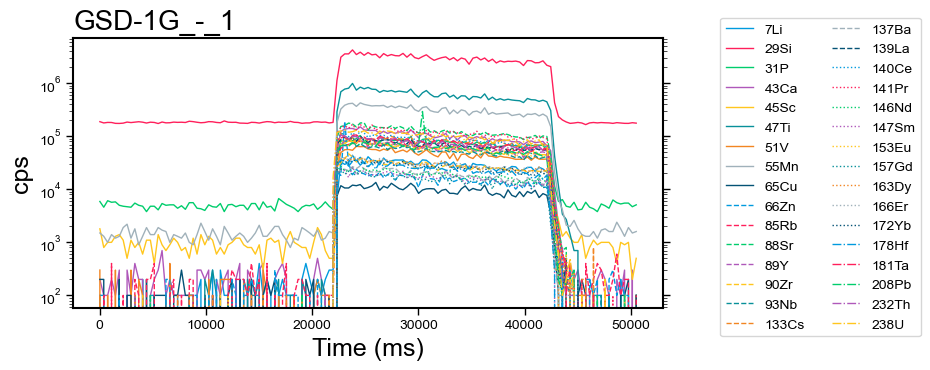

In [4]:
sample = 'GSD-1G_-_1'

ax = plotting.plot_timeseries_data(raw_data.loc[sample,:])
ax[0].set_title(sample)
ax[0].set_ylabel("cps")
ax[0].set_xlabel("Time (ms)")

We can see that the `208Pb` signal has a spike in it that is not observed in any of the other masses analyzed. Importantly, it is only for one sweep through the mass range. These can happen for a couple reasons (which are beyond the scope of this tutorial), but the important thing here is that they are analytical artifacts and do not reflect the composition of the material being analyzed. Note, however, that because we are on a log-scale with this plot, this spike in the data is almost an order of magnitude different from the rest of the values. This will significantly affect the standard deviation which is based on the mean:

$$ \sigma = \sqrt{\frac{\Sigma _i{\left|a_i - \overline{a}\right|^2}}{N}}$$

Focusing in on just the `208Pb` signal it becomes easier to see how this spike is one sweep through the mass range.

Text(0.5, 0, 'Time (ms)')

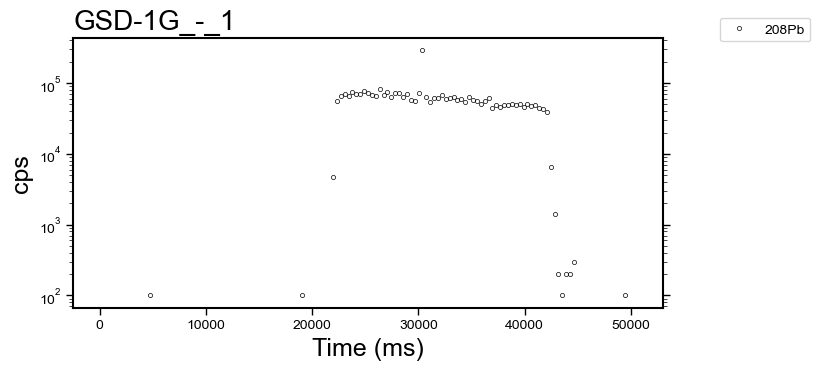

In [5]:
ax = plotting.plot_timeseries_data(
    raw_data.loc[sample,:], 
    analytes="208Pb",
    marker=".", 
    linestyle="", 
    mfc="none",
    mec = 'k'
)
ax[0].set_title(sample)
ax[0].set_ylabel("cps")
ax[0].set_xlabel("Time (ms)")

## Process data without de-spiking
This will be our control for comparing with our de-spiked data. This is just the normal `LaserTRAM` process outlined on the [Basic Usage](https://jlubbersgeo.github.io/lasertram/lasertram_tutorial/) page.

In [6]:
sample = samples[0]
spot = LaserTRAM(name=sample)
spot.get_data(raw_data.loc[sample, :])
bkgd_interval = (5, 10)
keep_interval = (25, 40)

spot.assign_int_std("29Si")
spot.assign_intervals(bkgd_interval, keep_interval)


spot.get_bkgd_data()
spot.subtract_bkgd()
spot.get_detection_limits()
spot.normalize_interval()
spot.make_output_report()


## Process data with de-spiking

This is largely the same as above, however, after data are normalized we de-spike the normalized ratios using a [z-score filter](https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/). This is a fairly basic, yet effective filter for looking for outliers in our data. We choose to implement this filter on our normalized data for a couple reasons:

1. If spikes happen in the raw data across numerous elements at the same timestamp, including the internal standard, this is a real spike - not an analytical artifact. When data are normalized it will be removed during that process. 
2. A z-score filter relies on some threshold to be set. Outside this threshold data are considered outliers. This threshold is based off the standard deviation of some group of data - in our case a moving window of data points. With our raw data, data may cover a wide range of counts per second values due to differences in ablation rate (e.g., ablation crater narrowing with depth). If our moving window is too big it causes the standard deviation to be larger as we are calculating this value of a population over a large range in values - even though this analysis may represent one homogeneous substance! Conversely, when data are normalized to an internal standard, if the substance is homogenous over a given window, the normalized values will not fluctuate nearly as much. This in turn makes the implementation of the z-score filter much more effective as we are taking the standard deviation over a window that no longer has the effects of differing ablation rate incorporated into the values. Rather the noise seen in the data reflects material homogeneity and instrument precision. Outliers can be easily removed at this point. Below we process the data and call the `despike_data()` method after normalizing and before we make the output report.


In [7]:
spot2 = LaserTRAM(name=f"{sample}-despiked")
spot2.get_data(raw_data.loc[sample, :])
bkgd_interval = (5, 10)
keep_interval = (25, 40)

spot2.assign_int_std("29Si")
spot2.assign_intervals(bkgd_interval, keep_interval)


spot2.get_bkgd_data()
spot2.subtract_bkgd()
spot2.get_detection_limits()
spot2.normalize_interval()
spot2.despike_data()
spot2.make_output_report()

## Compare results

We now compare results of the two and show that only the analytical artifacts are removed - not the true variability in the signal. First, as many of the attributes of a `LaserTRAM` object are `numpy` arrays (for ease of calculations) we'll turn the relevant ones into dataframes with some time information attached so they can be used by the built in plotting utilities:

In [8]:
normed = pd.DataFrame(spot.bkgd_subtract_normal_data, columns=spot.analytes)
time = spot.data.iloc[spot.int_start_idx : spot.int_stop_idx, :]["Time"]
normed.index = time.index
concat = pd.concat([time, normed], axis="columns")

normed2 = pd.DataFrame(spot2.bkgd_subtract_normal_data, columns=spot2.analytes)
normed2.index = time.index
concat2 = pd.concat([time, normed2], axis="columns")



Here we see that the datasets look largely similar with the exception of `208Pb`. This visual inspection, however, is pretty messy as it has all the analytes in there. 

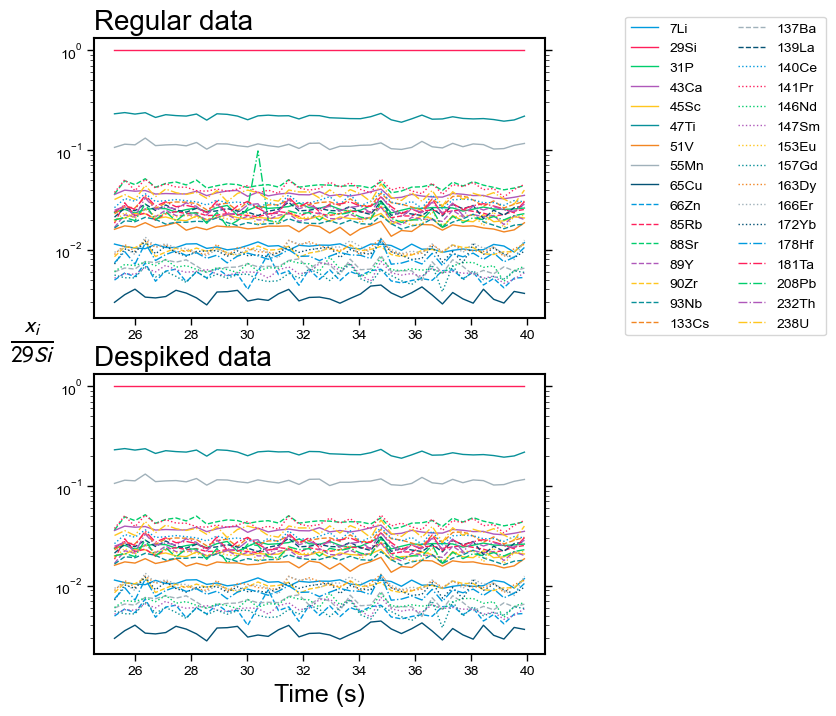

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

In [9]:
fig,ax = plt.subplots(2,2, figsize = (8,8),width_ratios = [.8,.2])

plotting.plot_timeseries_data(concat, ax = ax[0,:])
plotting.plot_timeseries_data(concat2, ax = ax[1,:])

ax[0,0].set_title("Regular data")
ax[1,0].set_title("Despiked data")

fig.supylabel(f"$\\frac{{x_i}}{{{spot.int_std}}}$", rotation=0,fontsize = 24 )
ax[0,0].set_xlabel("")
ax[1,0].set_xlabel("Time (s)")

ax[1,1].remove()

A better comparison, perhaps, is looking at the uncertainties for each analyte's signal. This will help confirm that our filter is not filtering out any real signal variability and only removing the analytical artifacts. A basic bar chart helps confirm this:

Text(0.5, 0, '')

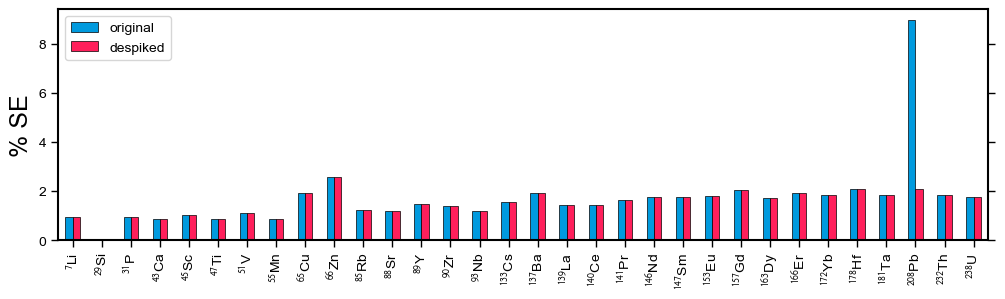

In [10]:
fig, ax = plt.subplots(figsize=(12, 3))
to_plot = pd.DataFrame(
    {
        "analyte": spot.analytes,
        "original": spot.bkgd_subtract_std_err_rel,
        "despiked": spot2.bkgd_subtract_std_err_rel,
    }
)
to_plot.plot(x = "analyte", y = ["original", "despiked"], kind = "bar",ax = ax, edgecolor = 'k',linewidth = 0.5)
labels = [analyte for analyte in spot.analytes]
labels = [
        "$^{{{}}}${}".format(
            re.findall(r"\d+", label)[0],
            label.replace(re.findall(r"\d+", label)[0], ""),
        )
        for label in labels
    ]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels,rotation = 90)
ax.set_ylabel('% SE')
ax.set_xlabel("")